<a href="https://colab.research.google.com/github/trinayasri/new/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, LSTM, RepeatVector, TimeDistributed
from keras.models import Model
from keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
(x_train,_),(x_test,_)=mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x_train=x_train.astype('float32') / 255
x_test=x_test.astype('float32')/255

In [ ]:
x_train_fc = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_fc = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
input_shape = (28, 28, 1)

In [ ]:
# Define the fully connected autoencoder
input_fc = Input(shape=(784,))
encoded_fc = Dense(32, activation='relu')(input_fc)
decoded_fc = Dense(784, activation='sigmoid')(encoded_fc)
autoencoder_fc = Model(input_fc, decoded_fc)

In [ ]:
# Define the sparse autoencoder
input_sparse = Input(shape=(784,))
encoded_sparse = Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_sparse)
decoded_sparse = Dense(784, activation='sigmoid')(encoded_sparse)
autoencoder_sparse = Model(input_sparse, decoded_sparse)

In [ ]:
# Define the recurrent autoencoder
input_rnn = Input(shape=(28, 28))
encoded_rnn = LSTM(32)(input_rnn)
decoded_rnn = RepeatVector(28)(encoded_rnn)
decoded_rnn = LSTM(32, return_sequences=True)(decoded_rnn)
decoded_rnn = TimeDistributed(Dense(28, activation='sigmoid'))(decoded_rnn)
autoencoder_rnn = Model(input_rnn, decoded_rnn)

In [ ]:
# Define the variational autoencoder
input_vae = Input(shape=(784,))
encoded_vae = Dense(256, activation='relu')(input_vae)
z_mean = Dense(2)(encoded_vae)
z_log_var = Dense(2)(encoded_vae)

In [ ]:
# Define the convolutional autoencoder
input_cnn = Input(shape=input_shape)
x_cnn = Conv2D(16, (3, 3), activation='relu', padding='same')(input_cnn)
x_cnn = MaxPooling2D((2, 2), padding='same')(x_cnn)
x_cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(x_cnn)
x_cnn = MaxPooling2D((2, 2), padding='same')(x_cnn)
x_cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(x_cnn)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(x_cnn)
x_cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_cnn)
x_cnn = UpSampling2D((2, 2))(x_cnn)
x_cnn = Conv2D(8, (3, 3), activation='relu', padding='same')(x_cnn)
x_cnn = UpSampling2D((2, 2))(x_cnn)
x_cnn = Conv2D(16, (3, 3), activation='relu')(x_cnn)
x_cnn = UpSampling2D((2, 2))(x_cnn)
decoded_cnn = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x_cnn)
autoencoder_cnn = Model(input_cnn, decoded_cnn)

In [ ]:
# Define a sampling function to sample from the learned distribution
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
z = layers.Lambda(sampling)([z_mean, z_log_var])
decoded_vae = Dense(784, activation='sigmoid')(z)
autoencoder_vae = Model(input_vae, decoded_vae)

In [ ]:
# Compile all the autoencoders
autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_cnn.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_sparse.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_rnn.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_vae.compile(optimizer='adam', loss='binary_crossentropy')
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load an example image
x = x_test[0]

In [ ]:
# Predict the output using each autoencoder
x_fc_pred = autoencoder_fc.predict(np.expand_dims(x.flatten(), axis=0)).reshape(28, 28)
x_cnn_pred = autoencoder_cnn.predict(np.expand_dims(x, axis=0)).reshape(28, 28)
x_sparse_pred = autoencoder_sparse.predict(np.expand_dims(x.flatten(), axis=0)).reshape(28, 28)
x_rnn_pred = autoencoder_rnn.predict(np.expand_dims(x, axis=0)).reshape(28, 28)
x_vae_pred = autoencoder_vae.predict(np.expand_dims(x.flatten(), axis=0)).reshape(28, 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


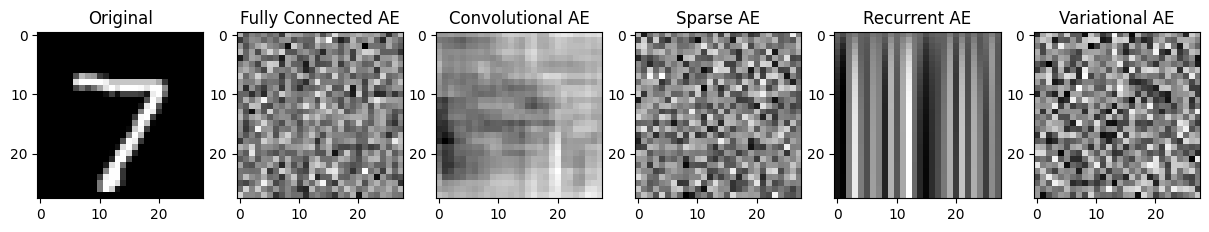

In [ ]:
# Plot the original image and the predicted outputs
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
axs[0].imshow(x, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(x_fc_pred, cmap='gray')
axs[1].set_title('Fully Connected AE')
axs[2].imshow(x_cnn_pred, cmap='gray')
axs[2].set_title('Convolutional AE')
axs[3].imshow(x_sparse_pred, cmap='gray')
axs[3].set_title('Sparse AE')
axs[4].imshow(x_rnn_pred, cmap='gray')
axs[4].set_title('Recurrent AE')
axs[5].imshow(x_vae_pred, cmap='gray')
axs[5].set_title('Variational AE')
plt.show()